### Import libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import os
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from nltk import ngrams


from util import preprocess_conversation, get_conversation_tokens
from util import convert_dataset_to_json, get_root_path

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

### Constants and dataset loading

In [7]:
DATASET_PATH = os.path.join(get_root_path(), 'dataset', 'toxic_conversation.csv')

print(f"[INFO] Loading dataset from {DATASET_PATH}")
df = pd.read_csv(DATASET_PATH)
print("[INFO] Dataset loaded successfully")

[INFO] Loading dataset from c:\Home\Uniba\CIPV-Classification-NLP\src\..\dataset\toxic_conversation.csv
[INFO] Dataset loaded successfully


### General info

In [8]:
print("[INFO] Dataset dimensions")
print(f"   Rows: {df.shape[0]}, Columns: {df.shape[1]}")

columns = df.columns.tolist()
print("\n\n", "-"*100, "\n[INFO] Dataset columns:")
for col in columns:
    print(f"   - {col}")

print("\n\n", "-"*100, "\n[INFO] First few rows of the dataset:")
print(df.head())

print("\n\n", "-"*100, "\n[INFO] Dataset statistics:")
print(df.describe(include='all').transpose())

[INFO] Dataset dimensions
   Rows: 1000, Columns: 6


 ---------------------------------------------------------------------------------------------------- 
[INFO] Dataset columns:
   - person_couple
   - conversation
   - name1
   - name2
   - explaination
   - toxic


 ---------------------------------------------------------------------------------------------------- 
[INFO] First few rows of the dataset:
                       person_couple                                       conversation      name1      name2                                       explaination toxic
0           Psicopatico e Adulatrice  1. "Hai assolutamente ragione. Sei così unico ...     Stelio  Desdemona  Questa conversazione tossica presenta diverse ...    Si
1  Manipolatore e Dipendente emotiva  Maurella                Ho notato che ultimame...  Eustochia   Maurella  Eustochia presenta un comportamento tossico po...    Si
2         Persona violenta e Succube  1. Ubaldo: "Sono arrabbiata perché ti sei ubri...

### Toxicity categories

[INFO] Toxicity category distribution
   - Psicopatico e Adulatrice                        100
   - Manipolatore e Dipendente emotiva               100
   - Persona violenta e Succube                      100
   - Narcisista e Succube                            100
   - Sadico-Crudele e Masochista                     100
   - Perfezionista Critico e Insicura Cronica        100
   - Vittimista e Crocerossina                       100
   - Dominante e Schiavo emotivo                     100
   - Geloso-Ossessivo e Sottomessa                   100
   - Controllore e Isolata                           100


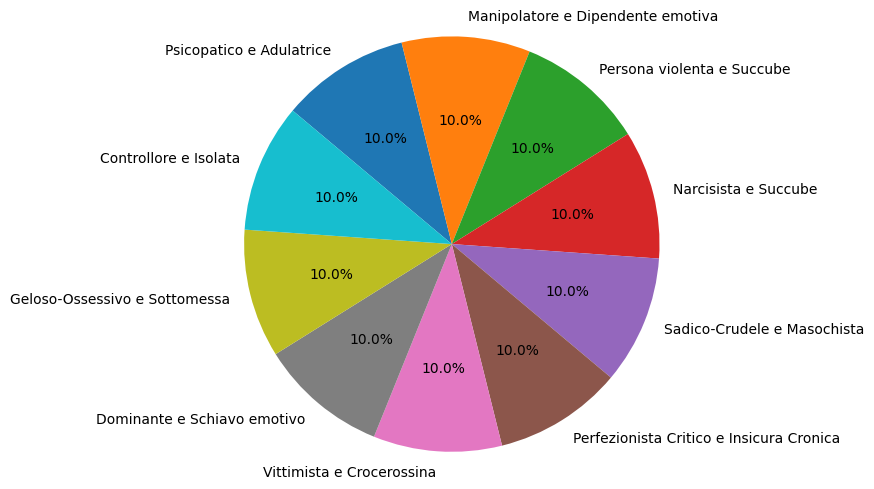

In [9]:
category_counts = df['person_couple'].value_counts()
print("[INFO] Toxicity category distribution")
for category, count in category_counts.items():
    print("   - {:<40} {:10}".format(category, count))

# Plotting the distribution of toxicity categories
plt.figure(figsize=(8, 5))
plt.pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    counterclock=False,
)
plt.axis('equal')
plt.tight_layout()
plt.show()

### Conversation

[INFO] Conversation length statistics

   Stats          | Characters          | Words               | Turns               
   -------------- | ------------------- | ------------------- | -------------------
   count          | 1000.0              | 1000.0              | 1000.0              
   mean           | 1029.917            | 159.816             | 8.363               
   std            | 422.5884512266161   | 69.2546485829677    | 3.931754022022447   
   min            | 223.0               | 23.0                | 1.0                 
   25%            | 682.75              | 105.0               | 6.0                 
   50%            | 882.5               | 135.0               | 6.0                 
   75%            | 1470.0              | 224.0               | 11.25               
   max            | 1796.0              | 312.0               | 32.0                


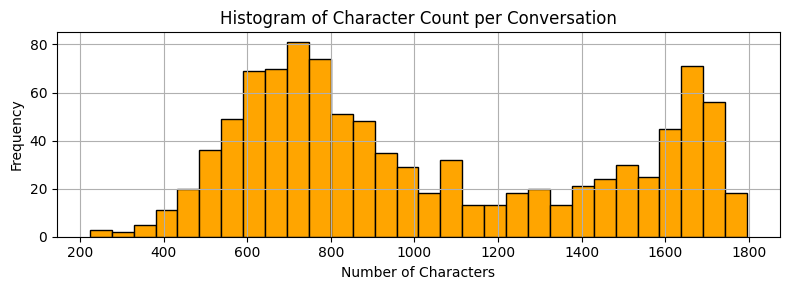

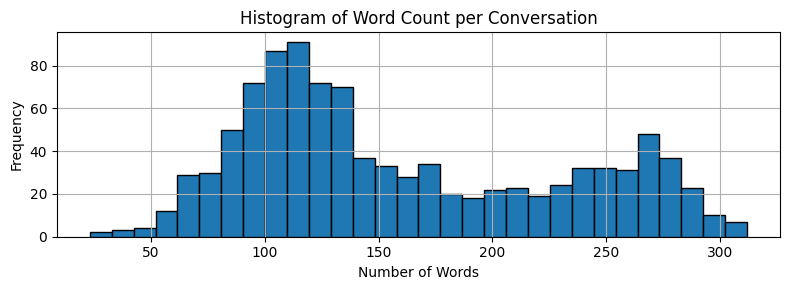

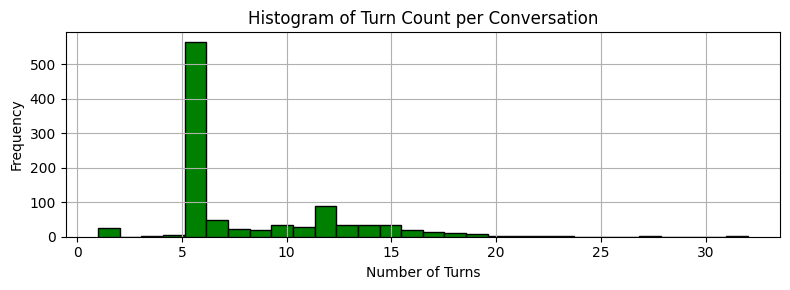



 ---------------------------------------------------------------------------------------------------- 
[INFO] Turn count statistics per toxic category

                              person_couple  count   mean  min  max
0                     Controllore e Isolata    909   9.09    1   20
1               Dominante e Schiavo emotivo   1048  10.48    1   19
2             Geloso-Ossessivo e Sottomessa    703   7.03    1   22
3         Manipolatore e Dipendente emotiva    731   7.31    1   17
4                      Narcisista e Succube    719   7.19    1   20
5  Perfezionista Critico e Insicura Cronica    773   7.73    6   18
6                Persona violenta e Succube   1097  10.97    1   22
7                  Psicopatico e Adulatrice    855   8.55    1   20
8               Sadico-Crudele e Masochista    757   7.57    4   27
9                 Vittimista e Crocerossina    771   7.71    1   32


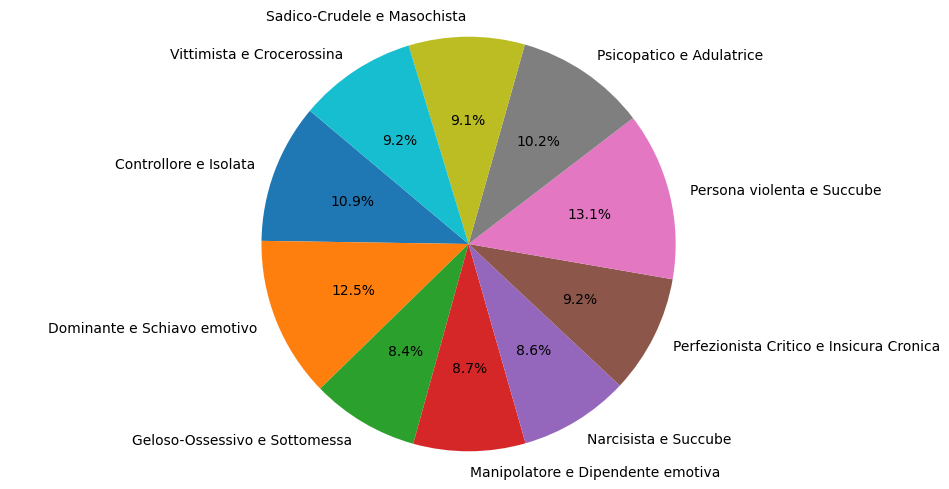



 ---------------------------------------------------------------------------------------------------- 
[INFO] Most common words in the dataset

   - essere                1891
   - te                    1841
   - fare                  1508
   - me                    1493
   - solo                  1446
   - so                    1297
   - così                  1186
   - cosa                  1063
   - sempre                 897
   - dispiace               892
   - felice                 887
   - voglio                 880
   - mai                    822
   - sì                     757
   - nulla                  649
   - troppo                 622
   - qualcosa               590
   - spero                  582
   - posso                  546
   - capisco                534


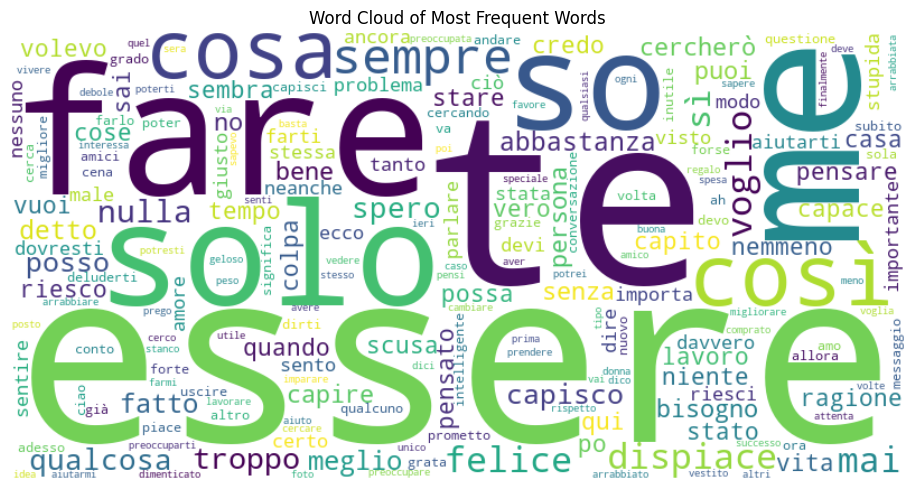

In [17]:
df['character_count'] = df['conversation'].str.len()
df['word_count'] = df['conversation'].str.split().apply(len)
df['turn_count'] = df['conversation'].apply(lambda x: len(preprocess_conversation(x, remove_stopwords=True).split('[SEP]')))
character_count_stats = df['character_count'].describe()
word_count_stats = df['word_count'].describe()
turn_count_stats = df['turn_count'].describe()

print("[INFO] Conversation length statistics\n")
print("   {:<15}| {:<20}| {:<20}| {:<20}".format("Stats", "Characters", "Words", "Turns"))
print("  ", "-"*14, "|", "-"*19, "|", "-"*19, "|", "-"*19)
for idx in range(len(character_count_stats)):
    print("   {:<15}| {:<20}| {:<20}| {:<20}".format(character_count_stats.index[idx], character_count_stats[idx], word_count_stats[idx], turn_count_stats[idx]))

plt.figure(figsize=(8, 3))
plt.hist(df['character_count'], bins=30, edgecolor='black', color='orange')
plt.title("Histogram of Character Count per Conversation")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 3))
plt.hist(df['word_count'], bins=30, edgecolor='black')
plt.title("Histogram of Word Count per Conversation")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 3))
plt.hist(df['turn_count'], bins=30, edgecolor='black', color='green')
plt.title("Histogram of Turn Count per Conversation")
plt.xlabel("Number of Turns")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


print("\n\n", "-"*100, "\n[INFO] Turn count statistics per toxic category\n")
turns_stats = df.groupby("person_couple")["turn_count"].agg(
    count="sum",
    mean="mean",
    min="min",
    max="max"
).reset_index()
print(turns_stats)

plt.figure(figsize=(10, 5))
plt.pie(turns_stats['count'], labels=turns_stats['person_couple'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.tight_layout()
plt.show()

all_words = df['conversation'].apply(lambda x: get_conversation_tokens(x, remove_stopwords=True)).explode()
word_freq = Counter(all_words)
print("\n\n", "-"*100, "\n[INFO] Most common words in the dataset\n")
for word, freq in word_freq.most_common(20):
    print(f"   - {word:<20} {freq:>5}")

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Most Frequent Words")
plt.tight_layout()
plt.show()

### N-grams

In [ ]:
all_tokens = df['conversation'].apply(lambda x: get_conversation_tokens(x, remove_stopwords=True)).explode().tolist()

# bigrams
bigrams = ngrams(all_tokens, 2)
bigram_freq = Counter(bigrams)
most_common_bigrams = bigram_freq.most_common(20)

print("\n[INFO] Most Common Bigrams:\n")
for bigram, freq in most_common_bigrams:
    print(f"   - {' '.join(bigram):<20} {freq:>5}")


# trigrams
trigrams = ngrams(all_tokens, 3)
trigram_freq = Counter(trigrams)
most_common_trigrams = trigram_freq.most_common(20)

print("\n[INFO] Most Common Trigrams:\n")
for trigram, freq in most_common_trigrams:
    print(f"   - {' '.join(trigram):<30} {freq:>5}")


# Plots
bigram_labels = [' '.join(bigram) for bigram, _ in most_common_bigrams]
bigram_values = [freq for _, freq in most_common_bigrams]

trigram_labels = [' '.join(trigram) for trigram, _ in most_common_trigrams]
trigram_values = [freq for _, freq in most_common_trigrams]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
# Bigrams
ax1.barh(range(len(most_common_bigrams)), bigram_values, align='center', color='skyblue')
ax1.set_yticks(range(len(most_common_bigrams)))
ax1.set_yticklabels(bigram_labels)
ax1.invert_yaxis()
ax1.set_xlabel('Frequency')
ax1.set_title('Most Common Bigrams')
# Trigrams
ax2.barh(range(len(most_common_trigrams)), trigram_values, align='center', color='m')
ax2.set_yticks(range(len(most_common_trigrams)))
ax2.set_yticklabels(trigram_labels)
ax2.invert_yaxis()
ax2.set_xlabel('Frequency')
ax2.set_title('Most Common Trigrams')

plt.tight_layout()
plt.show()

---------------------

### Convert CSV to JSON

In [ ]:
JSON_PATH = os.path.join(get_root_path(), 'dataset', 'toxic_conversation.json')

convert_dataset_to_json(DATASET_PATH, JSON_PATH)